In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
df1 = pd.read_csv("dataset1.csv")
df1.month = pd.to_datetime(df1.month)
df1.set_index("month", inplace=True)
df1.sort_index(inplace=True)

print(df1.info())
df1.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2018-01-31 to 2025-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       96 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB
None


,y
month,
2018-01-31,486.370312
2018-02-28,517.018280
2018-03-31,517.650581
2018-04-30,528.576952
2018-05-31,514.585551


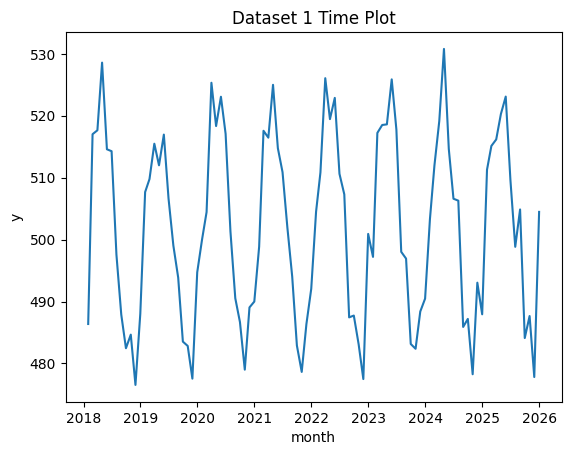

In [45]:
sns.lineplot(df1)
plt.title("Dataset 1 Time Plot")
plt.legend().remove()
plt.ylabel("y");

At first glance, this data heavily relies on seasonality for variation. The magnitude of seasonality remain consistent all throught out so let so we can say that the seasonal component is additive.  

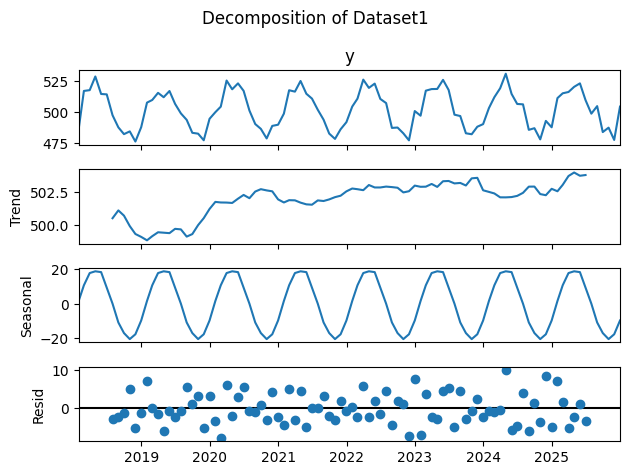

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df1['y'], model="additive", period=12)
fig = result.plot()
fig.suptitle("Decomposition of Dataset1")
plt.tight_layout();

Based on the decomposition plot above:
1. Minimal trend occur: Although there is a slight dip around 2019, on the larger scheme of the things, the trend went from 501 to 503--indicating a minimal trend happening.
2. Seaonal component is apparent. To be specific, yearly seasonality happens, flactuating from -20 to 20, in `Dataset1`, (since what we got is a monthly data, period=12). 
3. The variance is consistent all throughtout.
4. Residual is randomly flactuate around 0 from -10 to 10. There's no obvious pattern in the residuals, suggesting the seasonal decomposition has effectively captured the structured components of your time series.

With all the being said, it goes without saying that the trend/mean remain consistent all throughtout the span of data with the variation mostly determined by seasonality. 

Also, since seasonality exist, `dataset1` is non-stationary.

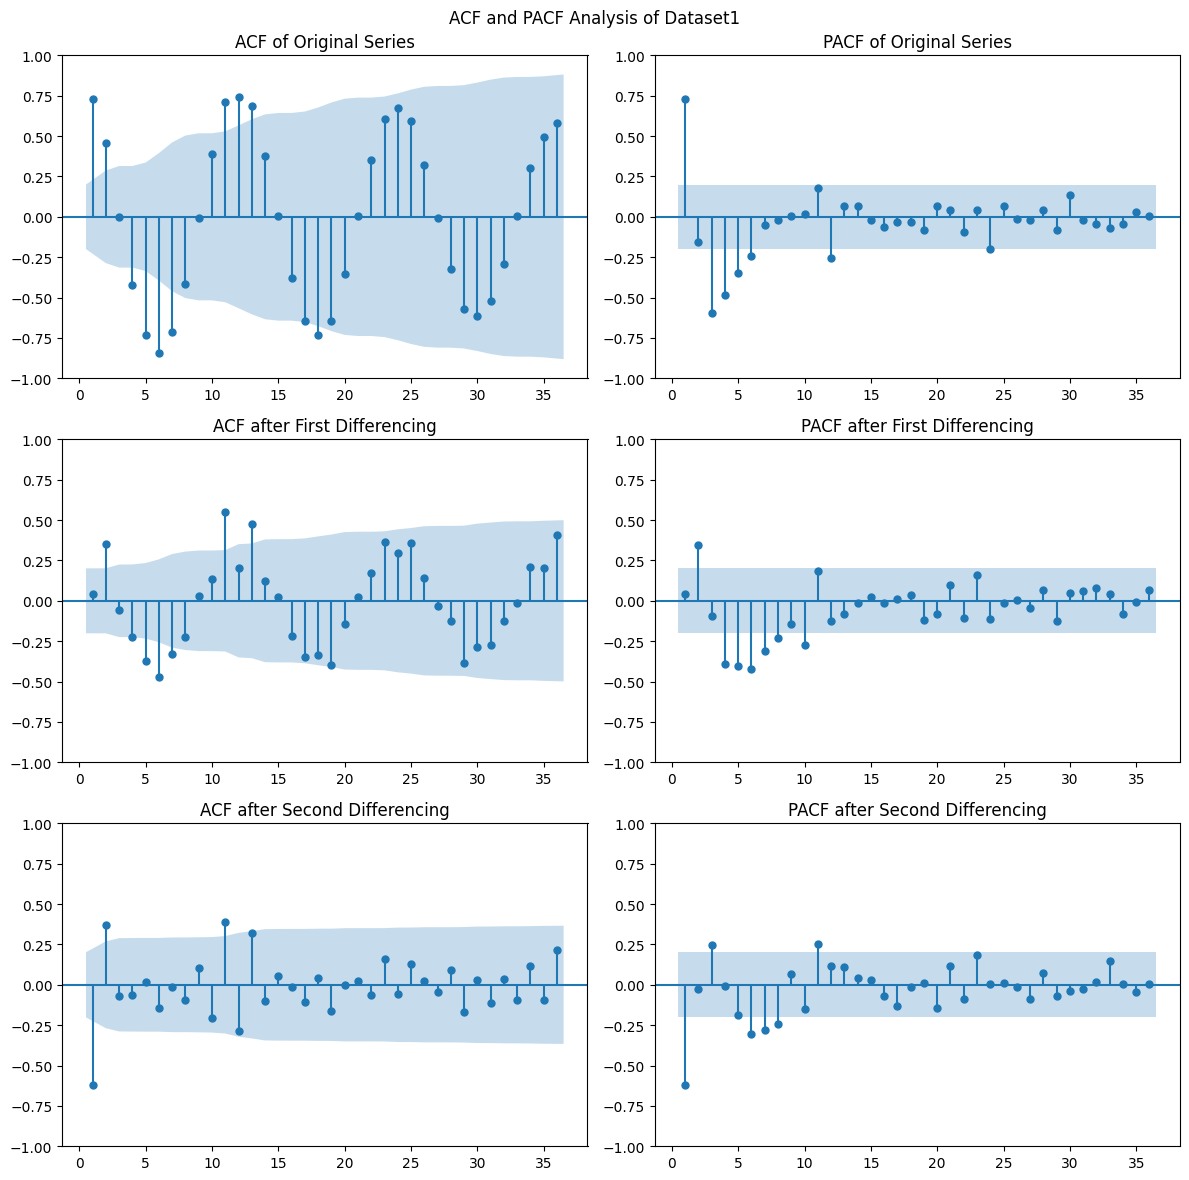

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Original data plots
plot_acf(df1['y'], lags=36, ax=axes[0, 0], zero=False, title='ACF of Original Series')
plot_pacf(df1['y'], lags=36, ax=axes[0, 1], zero=False, title='PACF of Original Series')

# First difference plots
first_dif = (df1 - df1.shift(1)).dropna()
plot_acf(first_dif['y'], lags=36, ax=axes[1, 0], zero=False, title='ACF after First Differencing')
plot_pacf(first_dif['y'], lags=36, ax=axes[1, 1], zero=False, title='PACF after First Differencing')

# Second difference plots
second_dif = (first_dif - first_dif.shift(1)).dropna()
plot_acf(second_dif['y'], lags=36, ax=axes[2, 0], zero=False, title='ACF after Second Differencing')
plot_pacf(second_dif['y'], lags=36, ax=axes[2, 1], zero=False, title='PACF after Second Differencing')

fig.suptitle('ACF and PACF Analysis of Dataset1', y=0.98)
plt.tight_layout()
plt.show()

Based on these plots, I can determine:

- **d=1**: First differencing removes most trend. Second differencing shows negative lag-1 spike indicating over-differencing.

**Period=12**: ACF of first-difference series shows a significant spike at lag 12. Now let us conduct seasonal differencing for the rest of the paramaters.

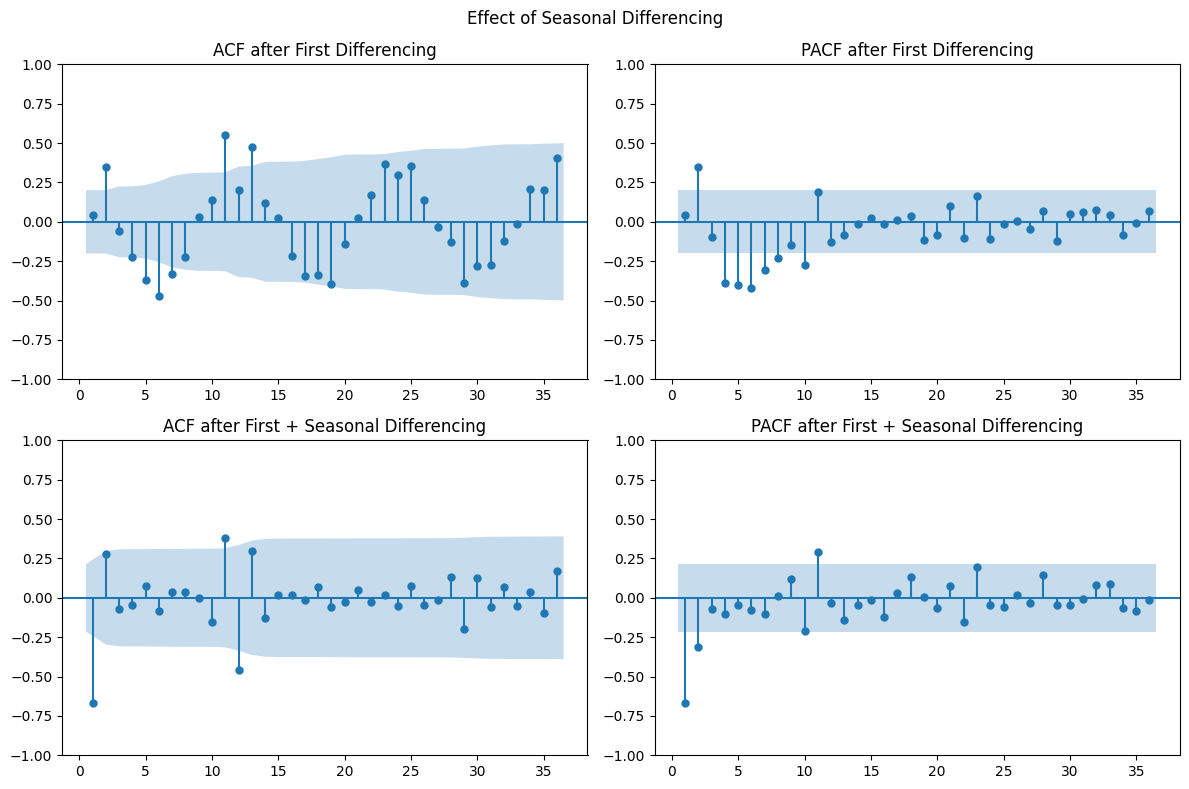

In [48]:
first_dif = (df1 - df1.shift(1)).dropna()

seasonal_dif = (first_dif - first_dif.shift(12)).dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Before
plot_acf(first_dif['y'], lags=36, ax=axes[0, 0], zero=False, 
         title='ACF after First Differencing')
plot_pacf(first_dif['y'], lags=36, ax=axes[0, 1], zero=False, 
          title='PACF after First Differencing')

# After
plot_acf(seasonal_dif['y'], lags=36, ax=axes[1, 0], zero=False, 
         title='ACF after First + Seasonal Differencing')
plot_pacf(seasonal_dif['y'], lags=36, ax=axes[1, 1], zero=False, 
          title='PACF after First + Seasonal Differencing')

plt.suptitle('Effect of Seasonal Differencing', y=0.98)
plt.tight_layout()
plt.show()

- **D=1**: Seasonal differencing is effective due to significant reduction in seasonal spikes at lags 12, 24, and 36 in both ACF and PACF plots. The strong seasonal pattern visible in the first-differenced series is largely eliminated after seasonal differencing.

- **P=1**: The PACF after seasonal differencing shows some remaining structure at seasonal lags, particularly around lag 12, suggesting a seasonal AR(1) component may be appropriate.

- **Q=1**: The ACF after seasonal differencing shows a significant spike around lag 12, indicating a seasonal MA(1) component would help model remaining seasonal effects.

- **p=2**: The PACF of the first-differenced series shows significant spikes at lag 2 followed by a cutoff, indicating an AR(2) process for the non-seasonal component.

- **q=1**: The strong negative spike at lag 1 in the ACF after both differencing operations suggests an MA(1) term would be appropriate.

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np

models = [
    # models from previous analysis
    ((1,1,1), (1,1,1,12), "SARIMA(1,1,1)(1,1,1)12"),
    ((2,1,1), (1,1,1,12), "SARIMA(2,1,1)(1,1,1)12"),
    
    # Models without seasonal MA term
    ((1,1,1), (1,1,0,12), "SARIMA(1,1,1)(1,1,0)12"),
    ((2,1,1), (1,1,0,12), "SARIMA(2,1,1)(1,1,0)12"),
    
    # Models without seasonal AR term
    ((1,1,1), (0,1,1,12), "SARIMA(1,1,1)(0,1,1)12"),
    ((2,1,1), (0,1,1,12), "SARIMA(2,1,1)(0,1,1)12"),
    
    # Simpler models
    ((1,1,0), (1,1,0,12), "SARIMA(1,1,0)(1,1,0)12"),
    ((0,1,1), (0,1,1,12), "SARIMA(0,1,1)(0,1,1)12"),
    
]

model_names = []
aic_values = []
bic_values = []
model_params = []
model_se = []
model_pvalues = []
model_convergence = []

for order, seasonal_order, name in models:
    try:
        model = SARIMAX(df1['y'], order=order, seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        
        model_names.append(name)
        aic_values.append(round(result.aic, 3))
        bic_values.append(round(result.bic, 3))
        
        params = result.params
        se = result.bse
        pvalues = result.pvalues
        
        model_params.append(params.to_dict())
        model_se.append(se.to_dict())
        model_pvalues.append(pvalues.to_dict())
        
        # Check for convergence issues
        max_se = se.max()
        model_convergence.append("Issue" if max_se > 10 else "OK")
        
        print(f"Fitted {name}")
    except Exception as e:
        print(f"Error fitting {name}: {e}")
        model_names.append(name)
        aic_values.append(np.nan)
        bic_values.append(np.nan)
        model_params.append({})
        model_se.append({})
        model_pvalues.append({})
        model_convergence.append("Failed")

# Create DataFrame with results
results_df = pd.DataFrame({
    'Model': model_names,
    'AIC': aic_values,
    'BIC': bic_values,
    'Parameters': model_params,
    'Std Errors': model_se,
    'P-values': model_pvalues,
    'Convergence': model_convergence
})

# Sort by AIC
results_df = results_df.sort_values('AIC')

# Display the results
results_df[['Model', 'AIC', 'BIC', 'Convergence']]

d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Fitted SARIMA(1,1,1)(1,1,1)12


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Fitted SARIMA(2,1,1)(1,1,1)12


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Fitted SARIMA(1,1,1)(1,1,0)12


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Fitted SARIMA(2,1,1)(1,1,0)12


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fitted SARIMA(1,1,1)(0,1,1)12


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fitted SARIMA(2,1,1)(0,1,1)12
Fitted SARIMA(1,1,0)(1,1,0)12


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\st

Fitted SARIMA(0,1,1)(0,1,1)12


,Model,AIC,BIC,Convergence
0,"SARIMA(1,1,1)(1,1,1)12",511.883,523.977,Issue
1,"SARIMA(2,1,1)(1,1,1)12",513.034,527.547,Issue
4,"SARIMA(1,1,1)(0,1,1)12",521.733,531.408,Issue
5,"SARIMA(2,1,1)(0,1,1)12",523.636,535.731,Issue
2,"SARIMA(1,1,1)(1,1,0)12",532.669,542.344,OK
3,"SARIMA(2,1,1)(1,1,0)12",534.629,546.723,OK
7,"SARIMA(0,1,1)(0,1,1)12",540.599,547.856,Issue
6,"SARIMA(1,1,0)(1,1,0)12",573.443,580.700,OK


In [50]:
model = SARIMAX(df1['y'], order=(1,1,1), seasonal_order=(1,1,0,12))

results = model.fit(disp=False)
print("SARIMA(1,1,1)(1,1,0)12 Results:")
print("="*50)
print(f"AIC: {results.aic:.3f}")
print(f"BIC: {results.bic:.3f}")
print("\nParameter Estimates:")
print("-"*50)
print(results.summary().tables[1])

d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


SARIMA(1,1,1)(1,1,0)12 Results:
AIC: 532.669
BIC: 542.344

Parameter Estimates:
--------------------------------------------------
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5635      0.095     -5.934      0.000      -0.750      -0.377
ma.L1         -0.9869      0.077    -12.829      0.000      -1.138      -0.836
ar.S.L12      -0.6902      0.083     -8.273      0.000      -0.854      -0.527
sigma2        27.6902      5.658      4.894      0.000      16.600      38.780


# SARIMA(1,1,1)(1,1,0)12 Model Analysis

**Fit Statistics:**
- AIC: 532.669, BIC: 542.344
- All parameters highly significant (p<0.001)

**Parameter Estimates and Interpretation:**
- **AR(1) = -0.5635** (SE: 0.095): The negative coefficient reflects the oscillatory patterns visible in the original time series, where values tend to reverse direction from one month to the next.

- **MA(1) = -0.9869** (SE: 0.077): This near-unity coefficient indicates strong short-term correction effects, aligning with the sharp fluctuations observed in the differenced series.

- **Seasonal AR(1) = -0.6902** (SE: 0.083): Captures the clear yearly seasonality evident in the decomposition plot. The negative coefficient indicates seasonal reversals.

- **d=1, D=1**: The need for both regular and seasonal differencing confirms the non-stationary seasonal components identified in our initial decomposition.

This model effectively captures the minimal upward trend, strong seasonal pattern, and short-term fluctuations that characterize the dataset. The parameter values align with the visual patterns observed in both the original and differenced series.

In [51]:
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

def plot_residual_analysis(model, figsize=(15, 10), lags=15, skip_initial=0):
    """
    Residual analysis for ARIMA/SARIMA models.
    
    Parameters:
    -----------
    model : ARIMA/SARIMA fitted model from statsmodels
    figsize : tuple, figure size (width, height)
    lags : int, number of lags for ACF/PACF and Ljung-Box test
    skip_initial : int, number of initial observations to skip (default=0)
    
    Returns:
    --------
    fig : matplotlib figure object
    """
    
    residuals = model.resid[skip_initial:]
    fitted = model.fittedvalues[skip_initial:]
    
    fig = plt.figure(figsize=figsize)
    
    # 1. Residuals over time
    ax1 = plt.subplot(3, 2, 1)
    residuals.plot(ax=ax1, color='steelblue', alpha=0.7)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax1.set_title('Residuals Over Time')
    ax1.set_ylabel('Residuals')
    ax1.grid(True, alpha=0.3)
    
    # 2. Histogram with normal overlay
    ax2 = plt.subplot(3, 2, 2)
    ax2.hist(residuals, bins=30, density=True, alpha=0.7, color='steelblue', edgecolor='black')
    mu, std = stats.norm.fit(residuals)
    xmin, xmax = ax2.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    ax2.plot(x, stats.norm.pdf(x, mu, std), 'r-', linewidth=2, 
             label=f'N(μ={mu:.2f}, σ={std:.2f})')
    ax2.set_title('Histogram of Residuals')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Q-Q plot
    ax3 = plt.subplot(3, 2, 3)
    stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title('Normal Q-Q Plot')
    ax3.grid(True, alpha=0.3)
    
    # 4. Residuals vs Fitted
    ax4 = plt.subplot(3, 2, 4)
    ax4.scatter(fitted, residuals, alpha=0.5, color='steelblue')
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax4.set_title('Residuals vs Fitted Values')
    ax4.set_xlabel('Fitted Values')
    ax4.set_ylabel('Residuals')
    ax4.grid(True, alpha=0.3)
    
    # 5. ACF
    ax5 = plt.subplot(3, 2, 5)
    plot_acf(residuals, lags=lags, ax=ax5, alpha=0.05)
    ax5.set_title('ACF of Residuals')
    ax5.grid(True, alpha=0.3)
    
    # 6. PACF
    ax6 = plt.subplot(3, 2, 6)
    plot_pacf(residuals, lags=lags, ax=ax6, alpha=0.05, method='ywm')
    ax6.set_title('PACF of Residuals')
    ax6.grid(True, alpha=0.3)
    
    title = f'{model.model.__class__.__name__} Residual Analysis'
    if skip_initial > 0:
        title += f' (skipped first {skip_initial} obs)'
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Diagnostic statistics
    print("=" * 50)
    print("RESIDUAL DIAGNOSTICS")
    if skip_initial > 0:
        print(f"(Skipping first {skip_initial} observations)")
    print("=" * 50)
    print(f"Mean: {residuals.mean():.6f}")
    print(f"Std:  {residuals.std():.4f}")
    print(f"Skew: {stats.skew(residuals):.4f}")
    print(f"Kurt: {stats.kurtosis(residuals):.4f}")
    
    # Shapiro-Wilk test
    stat, p = stats.shapiro(residuals[:5000])
    print(f"\nShapiro-Wilk: stat={stat:.4f}, p={p:.4f}")
    
    # Ljung-Box test
    lb_test = acorr_ljungbox(residuals, lags=lags, return_df=True)
    print(f"\nLjung-Box test (H0: no autocorrelation):")
    print(lb_test[['lb_stat', 'lb_pvalue']].round(4))
    
    return fig

RESIDUAL DIAGNOSTICS
(Skipping first 1 observations)
Mean: -2.969244
Std:  24.1245
Skew: -8.1439
Kurt: 72.1668

Shapiro-Wilk: stat=0.3125, p=0.0000

Ljung-Box test (H0: no autocorrelation):
    lb_stat  lb_pvalue
1    0.4635     0.4960
2    1.6012     0.4490
3    1.9041     0.5926
4    1.9232     0.7499
5    1.9578     0.8549
6    2.0979     0.9105
7    2.4448     0.9312
8    2.5008     0.9617
9    2.7394     0.9737
10   2.8331     0.9851
11   5.1778     0.9223
12   5.6749     0.9316
13   5.6794     0.9570
14   5.9604     0.9675
15   5.9769     0.9801


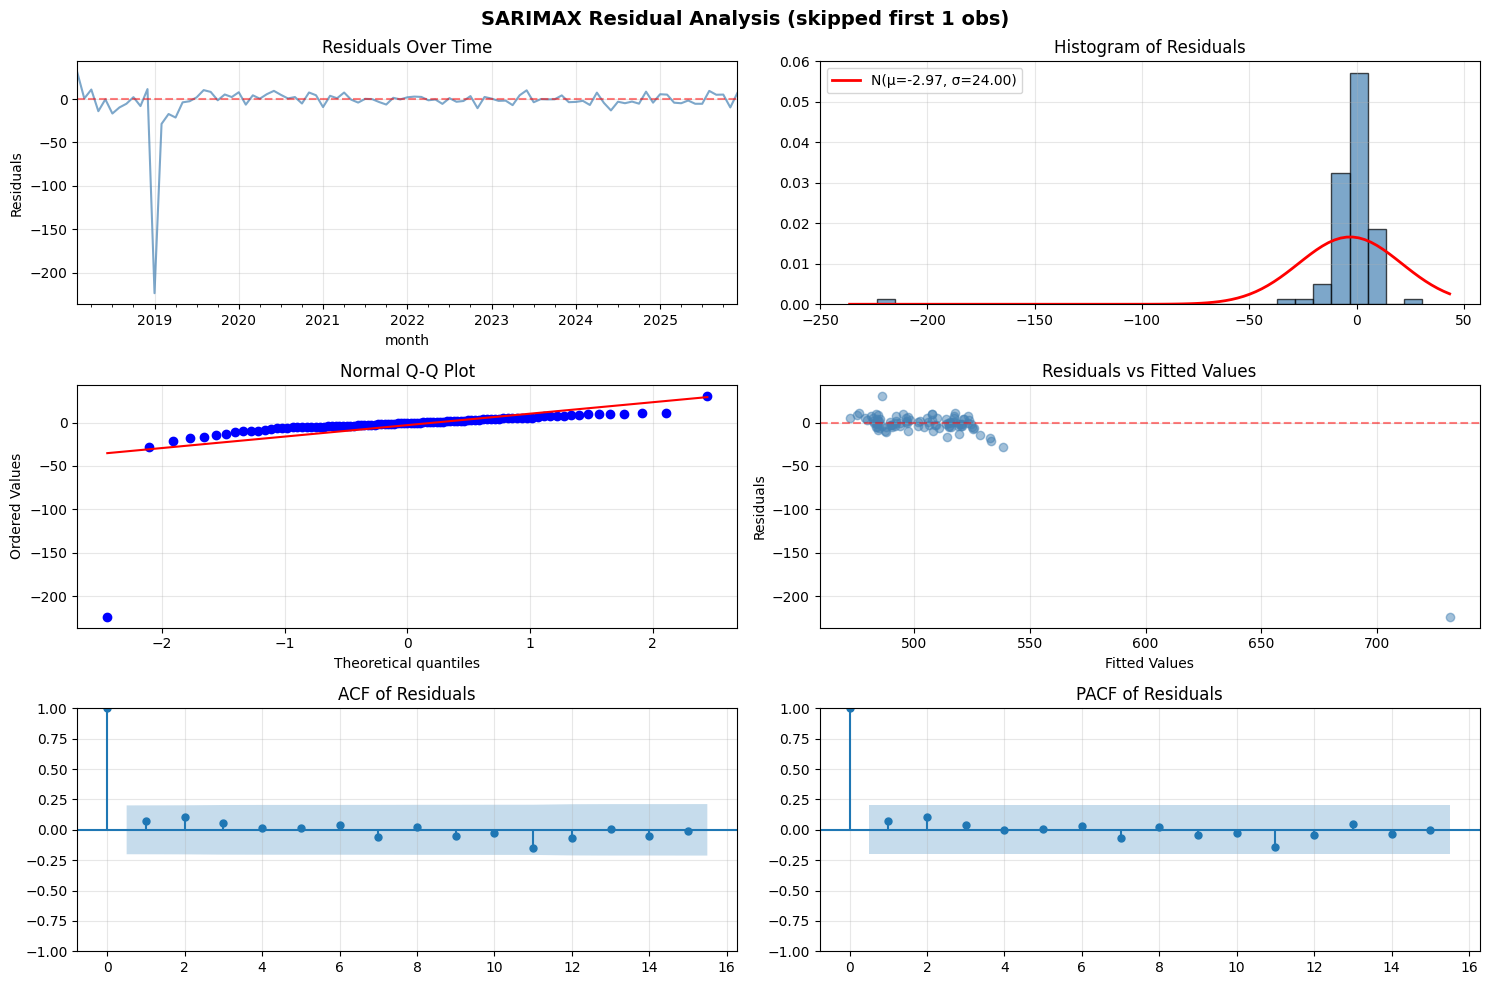

In [52]:
plot_residual_analysis(results, skip_initial=1);

- Residuals show departure from normality (Shapiro-Wilk p < 0.001), primarily due to the 2019 outlier event visible in the QQ-plot tails and high kurtosis (72.17).
- Residuals are centered around zero with minimal bias (mean = -2.97).
- No significant autocorrelation detected at any lag (all Ljung-Box p-values > 0.44).
- Homoscedasticity assumption is reasonably satisfied (Residuals vs Fitted plot shows consistent variance).

The model demonstrates strong performance despite the non-normality issue, which stems from a single extreme event in early 2019 rather than systematic model misspecification. The absence of autocorrelation indicates the SARIMA(1,1,1)(1,1,0)[12] structure adequately captures the temporal dynamics. 

While the outlier affects normality tests, it represents a genuine data point (possibly a crisis or exceptional event) that should be retained for historical accuracy. For improved normality, an intervention variable could be added for the 2019 event, but the current model remains suitable for forecasting given:
1. No autocorrelation (the most critical assumption for time series)
2. Stable variance across fitted values
3. The outlier's minimal impact on ongoing predictions

The model is appropriate for practical forecasting applications, though prediction intervals may be slightly conservative due to the inflated variance from the outlier.

We could of course create a new column with indicators that the time belongs to 2019 and therefore is an outlier (since we are using SARIMAX, we could do that) but practically speaking, we can use the current model.

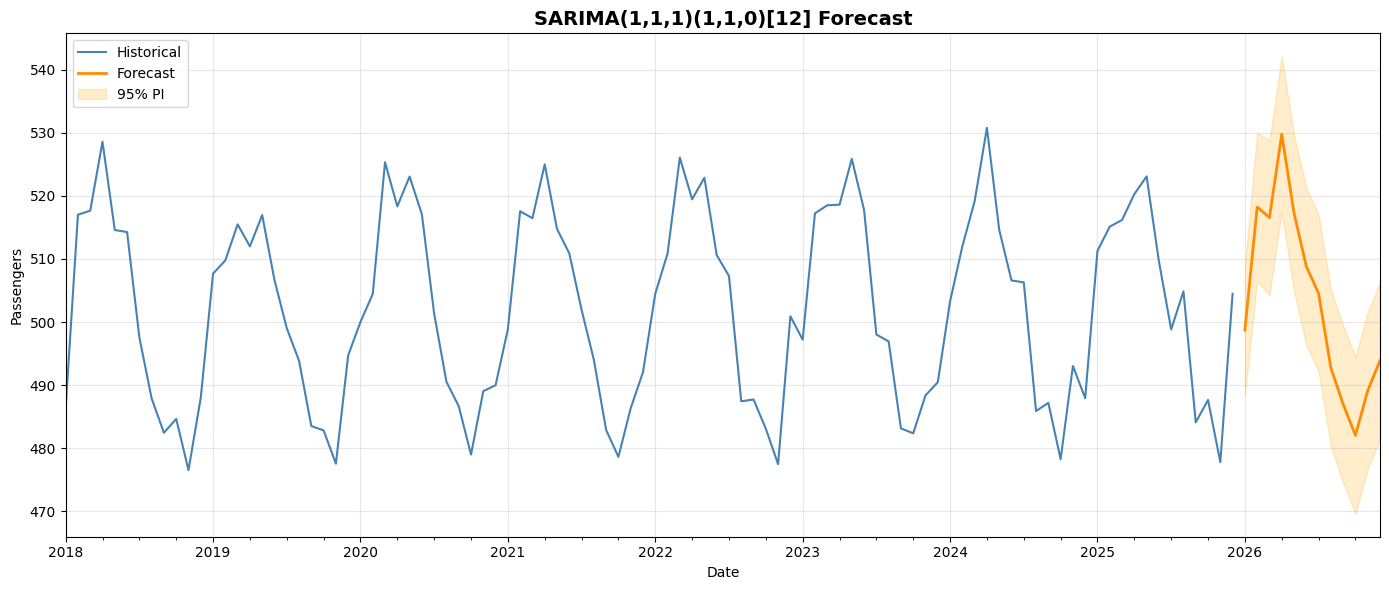


Forecast Summary:
            Forecast  Lower 95%  Upper 95%
2026-01-31     498.7      488.4      509.1
2026-02-28     518.2      506.5      530.0
2026-03-31     516.6      504.3      528.8
2026-04-30     529.8      517.4      542.1
2026-05-31     517.3      504.9      529.7
2026-06-30     508.8      496.4      521.2
2026-07-31     504.6      492.1      517.0
2026-08-31     492.7      480.3      505.2
2026-09-30     487.0      474.5      499.4
2026-10-31     482.0      469.6      494.5
2026-11-30     489.1      476.7      501.6
2026-12-31     493.9      481.5      506.3


In [ ]:
forecast = results.forecast(steps=12)
forecast_df = results.get_forecast(steps=12)
confidence_intervals = forecast_df.conf_int(alpha=0.05)

fig, ax = plt.subplots(figsize=(14, 6))

df1['y'].plot(ax=ax, label='Historical', color='steelblue', linewidth=1.5)

forecast.plot(ax=ax, label='Forecast', color='darkorange', linewidth=2)

ax.fill_between(confidence_intervals.index, 
                confidence_intervals.iloc[:, 0], 
                confidence_intervals.iloc[:, 1], 
                color='orange', alpha=0.2, label='95% PI')

ax.set_title('SARIMA(1,1,1)(1,1,0)[12] Forecast', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nForecast Summary:")
print("="*60)
forecast_summary = pd.DataFrame({
    'Forecast': forecast,
    'Lower 95%': confidence_intervals.iloc[:, 0],
    'Upper 95%': confidence_intervals.iloc[:, 1]
})
print(forecast_summary.round(1))

- The forecasted values are within the same range as the historical data.
- The peak and dip month of both forecasted values and historical data are the same occuring at the middle of each year as the peak.

In [ ]:
PI_width = confidence_intervals.iloc[:, 1] - confidence_intervals.iloc[:, 0]
print("PI Width Growth:")
print(f"Month 1:  {PI_width.iloc[0]:.1f}")
print(f"Month 6:  {PI_width.iloc[5]:.1f}")
print(f"Month 12: {PI_width.iloc[11]:.1f}")
print(f"Expansion ratio: {PI_width.iloc[11]/PI_width.iloc[0]:.2f}x")

PI Width Growth:
Month 1:  20.7
Month 6:  24.9
Month 12: 24.9
Expansion ratio: 1.20x


The 1.20x PI expansion is unusually small for a 12-month horizon, suggesting the seasonal component dominates uncertainty. This make sense since we got a stable and repeating seasonal component pattern for all the years--making it easier for the model to read seasonal component.

**Practical Implications**
1. The narrow intervals (±12 passengers) enable confident resource allocation. Can safely plan for 520-530 capacity in peak months.
2. The 2019 outlier inflates intervals slightly, providing conservative estimates - good for risk management.
3. Strong seasonal signal remains reliable throughout horizon, supporting annual staffing cycles.
4. Since the model was trained on a stable dataset, it may be overconfident and susciptible to break in the face of outliers (like in 2019) or future uncertainties. In such case, it is wise to add safety margins for long-term planning in case another outlier even occurs.

Train: 76 observations
Test: 20 observations


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)



Model Performance on Holdout Set:
MAE:  5.92
RMSE: 7.02
MAPE: 1.19%


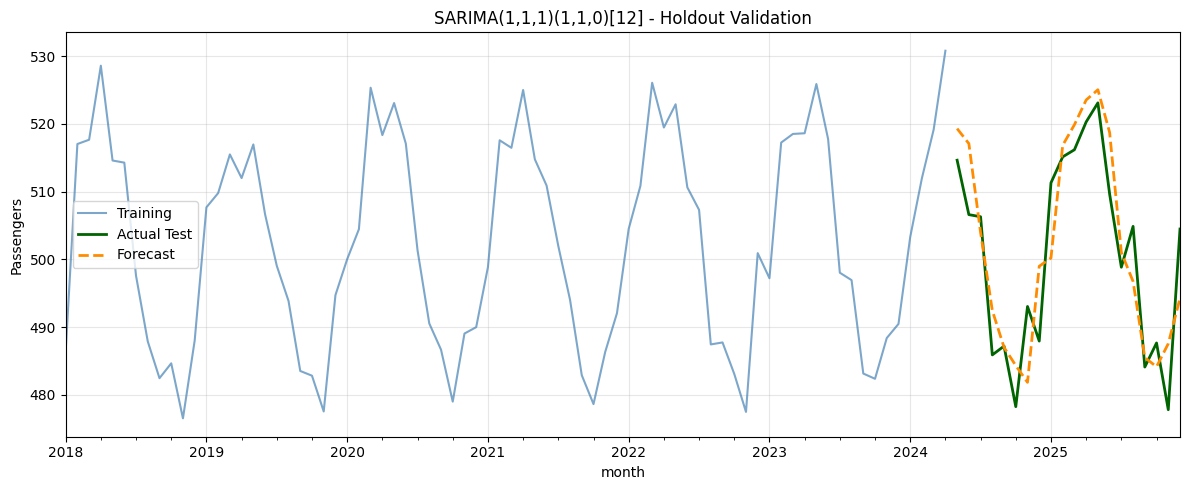

In [56]:
n = len(df1)
train_size = int(n * 0.8)
train = df1['y'][:train_size]
test = df1['y'][train_size:]

print(f"Train: {len(train)} observations")
print(f"Test: {len(test)} observations")

model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,0,12))
results = model.fit(disp=False)

forecast = results.forecast(steps=len(test))

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("\nModel Performance on Holdout Set:")
print("="*40)
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(12, 5))
train.plot(label='Training', color='steelblue', alpha=0.7)
test.plot(label='Actual Test', color='darkgreen', linewidth=2)
pd.Series(forecast, index=test.index).plot(label='Forecast', 
                                           color='darkorange', linewidth=2, linestyle='--')
plt.title('SARIMA(1,1,1)(1,1,0)[12] - Holdout Validation')
plt.legend()
plt.ylabel('Passengers')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Metrics Evaluation**:
- MAPE of 1.19% indicates excellent relative accuracy
- RMSE (7.02) > MAE (5.92) suggests occasional larger errors
- Visual inspection shows strong seasonal tracking but slight phase lag
**Key Tradeoff and Robustness Concerns**:
Although we could use more complex model like adding an exogenous variables and using SARIMAX to reduce the errors but it ought to risk overfitting and may not be ideal when another outlier event occurs--even more than what the model has now (due to current stability of the dataset)
